In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import result_utils

In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_5/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_5/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_5/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_5/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_5/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_5/test_.txt



1H2-16O__POKAZATEL


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.83it/s]


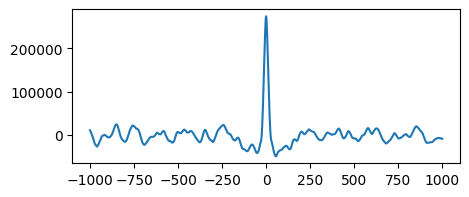


1H2-18O__HotWat78


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.88it/s]


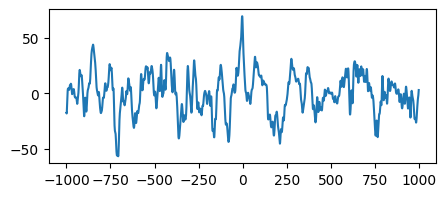


1H2-17O__HotWat78


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.93it/s]


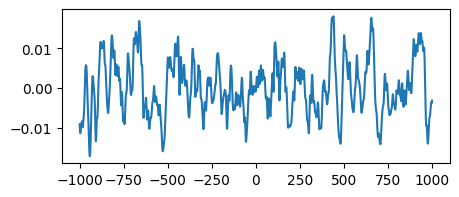


12C-16O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.89it/s]


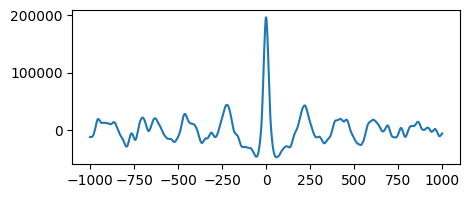


13C-16O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.79it/s]


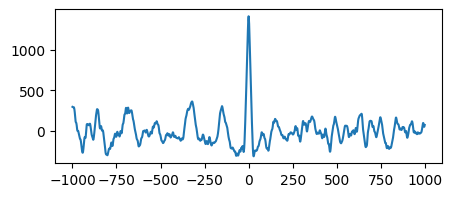


12C-18O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.85it/s]


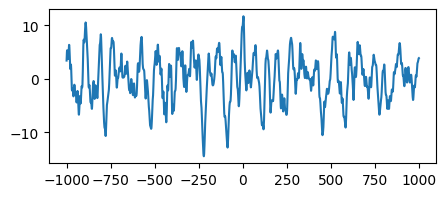


12C-17O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.99it/s]


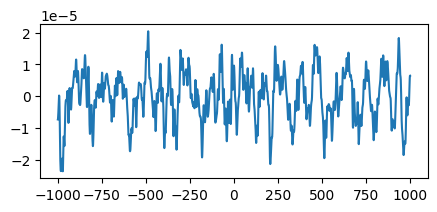


12C-1H4__MM


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.95it/s]


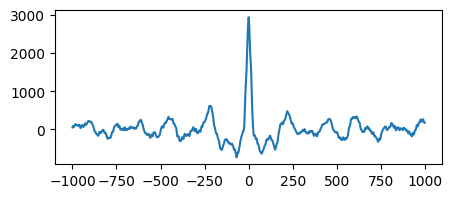


14N-1H3__CoYuTe


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.89it/s]


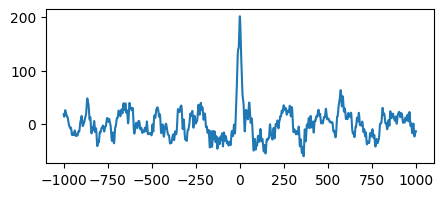


12C-16O2__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.08it/s]


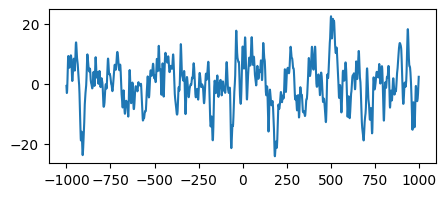


1H-12C-14N__Harris


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.96it/s]


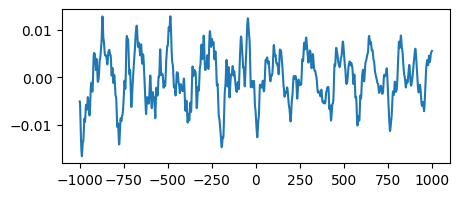


1H-19F__Coxon-Hajig


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.94it/s]


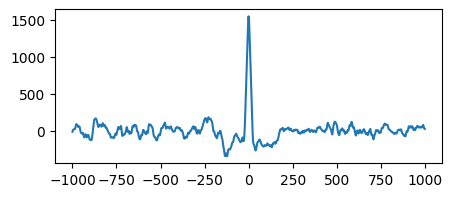


1H2-32S__AYT2


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.84it/s]


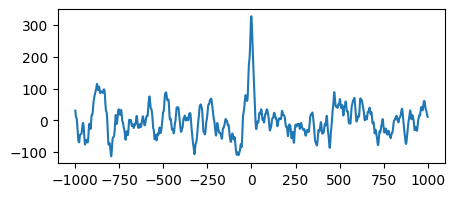


23Na__Kurucz


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.92it/s]


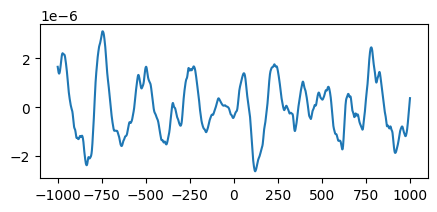


39K__Kurucz


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 37.91it/s]


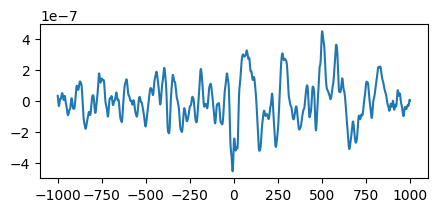


H2

He

1H2-16O__POKAZATEL


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.44it/s]


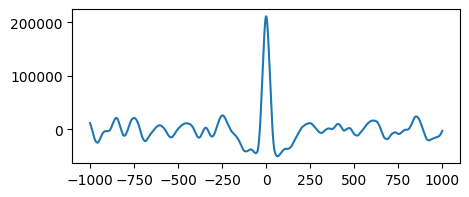


1H2-18O__HotWat78


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.44it/s]


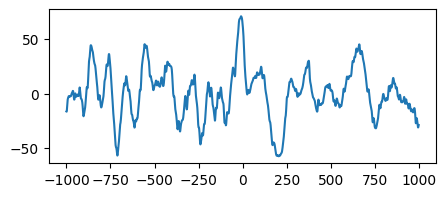


1H2-17O__HotWat78


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.44it/s]


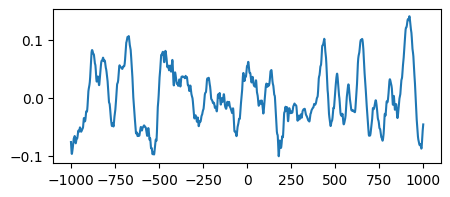


12C-16O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.39it/s]


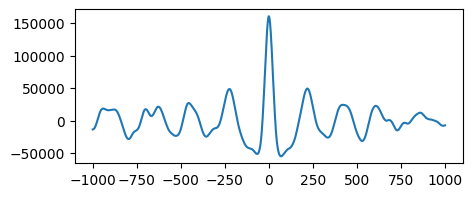


13C-16O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.43it/s]


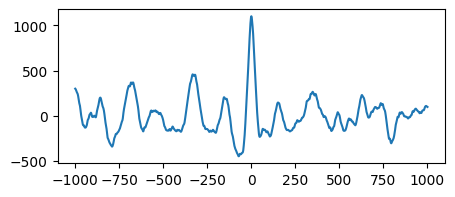


12C-18O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.23it/s]


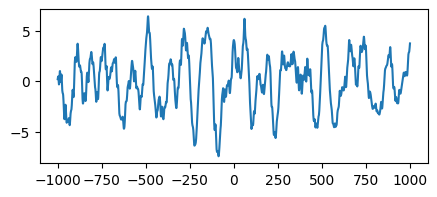


12C-17O__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.31it/s]


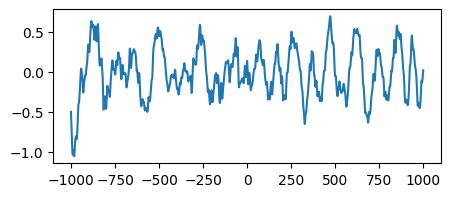


12C-1H4__MM


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.21it/s]


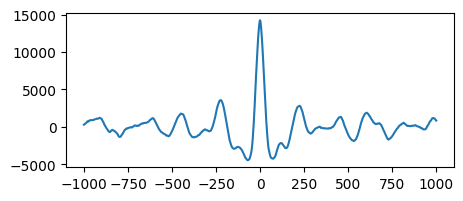


14N-1H3__CoYuTe


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.25it/s]


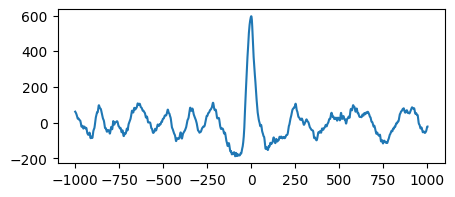


12C-16O2__HITEMP


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.22it/s]


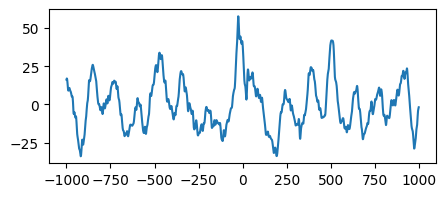


1H-12C-14N__Harris


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.25it/s]


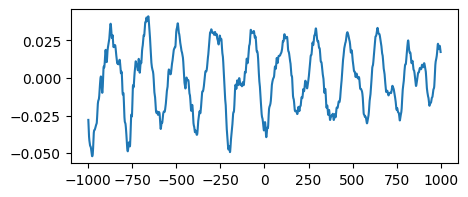


1H-19F__Coxon-Hajig


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.08it/s]


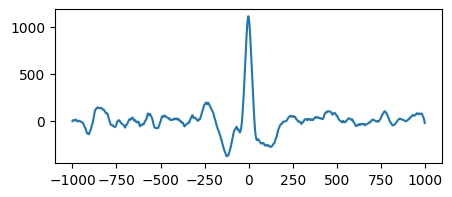


1H2-32S__AYT2


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.03it/s]


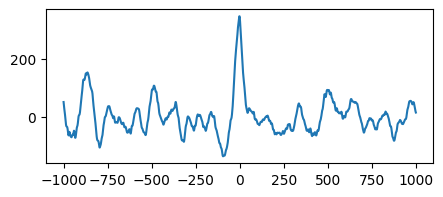


23Na__Kurucz


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.32it/s]


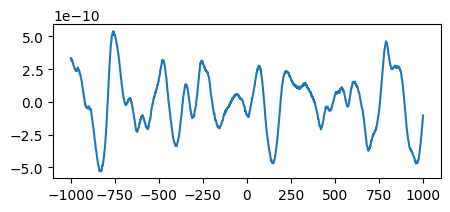


39K__Kurucz


100%|███████████████████████████████████████| 2001/2001 [00:52<00:00, 38.38it/s]


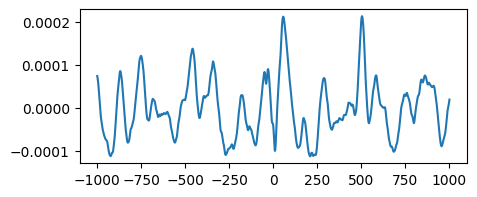


H2

He


In [3]:
import copy

def get_CCF(Res):
    
    Res.load_components(['Chem'])
    m_set = Res.model_settings[0]
    all_line_species = np.array(Res.Chem[m_set].line_species)

    #Res.get_model_spectrum(line_species_to_exclude=None, apply_rot_broad=False)
    Res.load_components(['m_spec_broad'])
    m_spec_broad_init = copy.deepcopy(Res.m_spec_broad)

    # all_line_species = np.array([
    #     '13C-16O__HITEMP', '12C-18O__HITEMP', '12C-17O__HITEMP', '12C-1H4__MM', '14N-1H3__CoYuTe', '1H-19F__Coxon-Hajig', '1H2-32S__AYT2',
    #     '1H2-16O__POKAZATEL', '1H2-18O__HotWat78', '1H2-17O__HotWat78', '12C-16O__HITEMP',
    #     '12C-16O2__AMES', '1H-12C-14N__Harris', '23Na__Kurucz', '39K__Kurucz', 'H2', 'He'
    #     ])

    all_CCF = {}
    
    for line_species in all_line_species:
        
        print('\n'+line_species)
        if line_species in ['MMW','H2','He']:
            continue

        # Model w/o species X
        Res.get_model_spectrum(line_species_to_exclude=[line_species])
        m_spec_to_subtract = copy.deepcopy(Res.m_spec_broad)

        # Model w/o all other species
        # line_species_to_exclude = all_line_species[all_line_species != line_species]
        # Res.get_model_spectrum(line_species_to_exclude=line_species_to_exclude)#, apply_rot_broad=False)
        # m_spec_template = copy.deepcopy(Res.m_spec_broad)

        #Res.get_model_spectrum(line_species_to_exclude=[line_species], apply_rot_broad=False)
        #m_spec_to_subtract_from_template = copy.deepcopy(Res.m_spec_broad)

        m_spec_template = copy.deepcopy(Res.m_spec_broad)
        for m_set in Res.model_settings:
            m_spec_template[m_set].flux = [
                m_spec_broad_init[m_set].flux[i] - m_spec_to_subtract[m_set].flux[i] \
                for i in range(len(m_spec_broad_init[m_set].flux))
                ]

        kwargs = dict(
            filter_type='savgol', window_length=501, polyorder=2, mode='interp', 
            )
        rv, CCF = Res.get_CCF(
            m_spec_template=m_spec_template, 
            m_spec_to_subtract=m_spec_to_subtract, 
            high_pass_filter={
                #'m_res': result_utils.HighPassFilter(), # Filter on model
                #'d_res': result_utils.HighPassFilter(), # Filter on data
                #'m_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on model
                #'d_res': result_utils.HighPassFilter(filter_type='nanmedian', size=301), # Filter on data
                'm_res': result_utils.HighPassFilter(**kwargs), # Filter on model
                'd_res': result_utils.HighPassFilter(**kwargs), # Filter on data
                },
            #rv=np.arange(-500,500,1),
            #rv=np.arange(-300,300,2),
            #plot=True, 
            )
        all_CCF[line_species] = CCF

        plt.figure(figsize=(5,2))
        plt.plot(rv, CCF.sum(axis=-1))
        plt.show()

    return rv, all_CCF

rv, all_CCF_A = get_CCF(A)
rv, all_CCF_B = get_CCF(B)

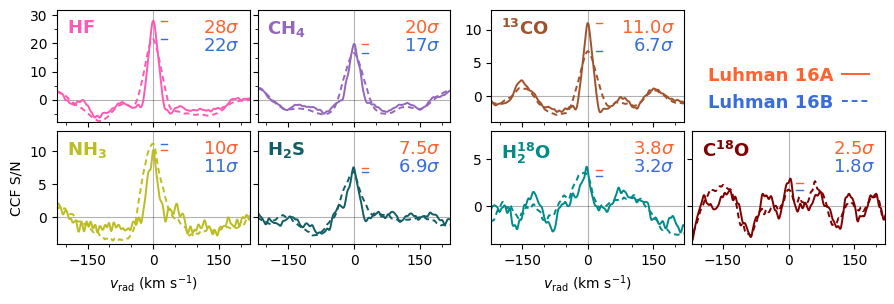

In [147]:
rv_A = A.ParamTable.get('rv')
rv_B = B.ParamTable.get('rv')
rv_A, rv_B = 0., 0.

xlim = (-220,220)
xticks_minor = np.arange(-200,201,50)
xticks = np.arange(-150,151,150)

ylim = [(-8,32), (-4,13), (-4,13), (-4,8)]
yticks_minor = np.arange(-5,31,5)
#yticks = np.arange(0,31,10)
lw_m = 1.4

species_to_plot = np.array([
    [('1H-19F__Coxon-Hajig', 'HF', '#FF59B4'), ('12C-1H4__MM', 'CH_4', 'C4')], 
    [('14N-1H3__CoYuTe', 'NH_3', 'C8'), ('1H2-32S__AYT2', 'H_2S', '#135D64')],
    [('13C-16O__HITEMP', '^{13}CO', 'sienna'), None],
    [('1H2-18O__HotWat78', 'H_2^{18}O', 'darkcyan'), ('12C-18O__HITEMP', 'C^{18}O', 'maroon')]
], dtype=object)

fig = plt.figure(figsize=(9,3))
gs = fig.add_gridspec(nrows=2, ncols=5, hspace=0.08, wspace=0.05, width_ratios=[1,1,0.13,1,1])
ax = np.array([
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],
    [fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4])],
    [fig.add_subplot(gs[1,3]), fig.add_subplot(gs[1,4])],
    ])

for i, species_row in enumerate(species_to_plot):
    for j, items in enumerate(species_row):
        
        if items is None:
            ax[i,j].set_axis_off()
            handle_A, = ax[i,j].plot(np.nan, np.nan, color=color_A, lw=lw_m)
            handle_B, = ax[i,j].plot(np.nan, np.nan, color=color_B, lw=lw_m, ls=(0,(3,2)))
            ax[i,j].legend(
                loc='lower center', bbox_to_anchor=(0.5,-0.05), frameon=False, 
                handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
                markerfirst=False, handlelength=1.5, handletextpad=0.5, 
                labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
            )

            #ax[4].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', ylabel='CCF S/N')
            continue
        line_species_j, label_j, color_j = items

        CCF_SNR_A = result_utils.convert_CCF_to_SNR(rv, all_CCF_A[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        CCF_SNR_B = result_utils.convert_CCF_to_SNR(rv, all_CCF_B[line_species_j][:,:].sum(axis=-1), rv_sep=300)
        ax[i,j].plot(rv+rv_A, CCF_SNR_A, lw=lw_m, c=color_j)
        ax[i,j].plot(rv+rv_B, CCF_SNR_B, lw=lw_m, c=color_j, ls=(0,(3,2)))

        # Reference lines
        ax[i,j].axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
        ax[i,j].axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
        ax[i,j].plot([18,32], [CCF_SNR_A[rv==0]]*2, c=color_A, lw=1)
        ax[i,j].plot([18,32], [CCF_SNR_B[rv==0]]*2, c=color_B, lw=1)

        # Print SNR in corner
        sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.1f}'
        sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.1f}'
        if len(sigma_A)==4 and len(sigma_B)==4:
            sigma_A = f'{CCF_SNR_A[rv==0].flatten()[0]:.0f}'
            sigma_B = f'{CCF_SNR_B[rv==0].flatten()[0]:.0f}'

        sigma_A = r'${'+sigma_A+r'\sigma}$'
        sigma_B = r'${'+sigma_B+r'\sigma}$'
        ax[i,j].annotate(
            sigma_A, xy=(0.95,0.92), xycoords='axes fraction', ha='right', va='top', color=color_A, fontsize=13
            )
        ax[i,j].annotate(
            sigma_B, xy=(0.95,0.76), xycoords='axes fraction', ha='right', va='top', color=color_B, fontsize=13
            )

        # Print molecule name in corner
        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        ax[i,j].annotate(
            label_j, xy=(0.05,0.92), xycoords='axes fraction', ha='left', va='top', color=color_j, fontsize=13
            )

        # Ticks and labels
        ax[i,j].set_yticks(yticks_minor, minor=True)
        ax[i,j].set_xticks(xticks_minor, minor=True)
        ax[i,j].set(xlim=xlim, ylim=ylim[i], xticks=xticks)#, xticks_minor=xticks_minor)
        
        if j != 0:
            ax[i,j].set_yticklabels([])

ax[1,0].set(ylabel=r'CCF S/N', xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')
ax[3,0].set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$')

plt.subplots_adjust(left=0.06, bottom=0.17, top=0.95, right=0.98)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()